In [2]:
from mydaq import MyDAQ
import matplotlib.pyplot as plt
import numpy as np



Reading Code ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [71]:
daq = MyDAQ()
daq.name = 'MyDAQ2'

# Set some basic values
samplerate = 200000
daq.samplerate = samplerate

amplitude= 1
duration = 12

# We define which channels to use 
readChannels = 'AI0'
filename = 'Test'



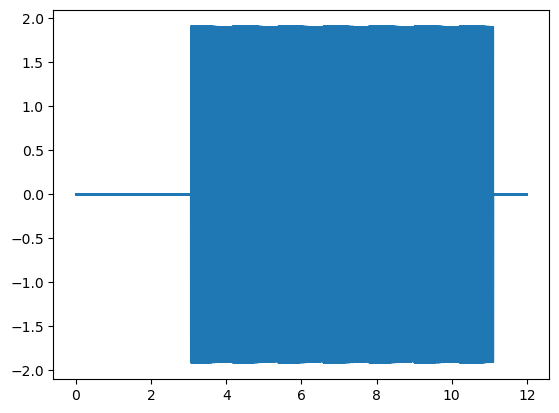

In [72]:
# Do the meaurement with MyDAQ
AI0_voltage = daq.read(duration, readChannels)


voltage_out = AI0_voltage # The second input channel is the voltage out over the breadboard component
time_array = daq.getTimeArray(duration, samplerate)

plt.plot(time_array, voltage_out)
plt.show()
# Save the data to a file

np.savez(f"data/{filename}", time=time_array, voltage=AI0_voltage)



Reading Code End---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Analysis ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[-0.00362414 -0.00427591 -0.00232059 ... -0.0046018  -0.0046018
 -0.00362414]


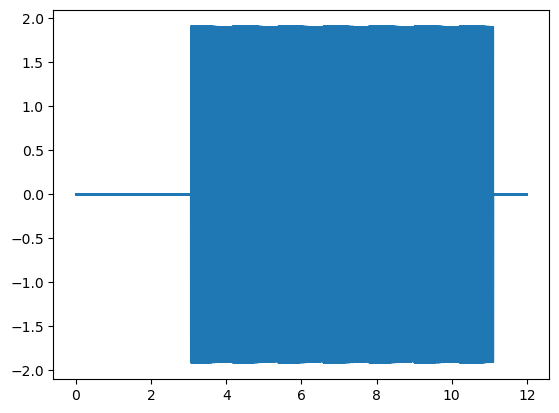

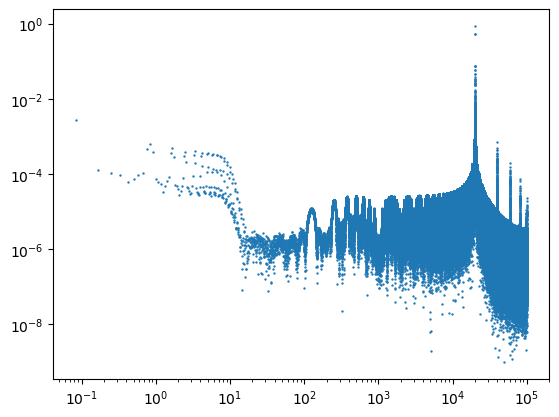

0.8754825927915411


In [73]:

data = np.load(f'data/{filename}.npz')
time_array = data['time']
voltage_out = data['voltage']
print(voltage_out)

plt.plot(time_array, voltage_out)
plt.show()

# Make hanning window for spectral leackage
hanning_window = np.hanning(len(voltage_out))

# Apply the window to the signal
AI0_voltage = AI0_voltage * hanning_window
freqs, fft_values = daq.performRFFT(AI0_voltage, samplerate)

plt.scatter(freqs, np.abs(fft_values), s=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()
print(np.max(np.abs(fft_values)))


In [10]:


def string_to_bitstream(message):
    
    """
    Converts a string to a list of bits (0s and 1s) using ASCII encoding.

    Example: "hi" -> [0,1,1,0,1,0,0,0, 0,1,1,0,1,0,0,1]
    """
    bitstream = []
    for char in message:
        ascii_val = ord(char)  # ASCII value
        bits = format(ascii_val, '08b')  # 8-bit binary string
        bitstream.extend([int(b) for b in bits])
    return bitstream
def bpsk_modulate(bitstream, bit_rate=1e3, carrier_freq=20e3, sampling_rate=samplerate):
    """
    BPSK modulator.

    Parameters:
        bitstream      : list or array of bits (0s and 1s)
        bit_rate       : how many bits per second
        carrier_freq   : carrier frequency in Hz
        sampling_rate  : samples per second (must be >> carrier_freq)
    
    Returns:
        t              : time array
        dds_wave : the BPSK modulated signal
    """
    bitstream = np.array(bitstream)
    T_bit = 1 / bit_rate
    samples_per_bit = int(sampling_rate * T_bit)

    # Time array for the whole signal
    t = np.arange(0, len(bitstream) * T_bit, 1 / sampling_rate)
    
    # Phase values: 0 for bit 0, pi for bit 1
    phase_shifts = np.pi * bitstream.repeat(samples_per_bit)
    
    # Carrier
    carrier = 10*np.cos(2 * np.pi * carrier_freq * t + phase_shifts)
    
    return t, carrier, phase_shifts
def bpsk_demodulate(received_signal, bit_rate=1e3, carrier_freq=20e3, sampling_rate=samplerate):
    """
    BPSK demodulator using correlation method.

    Parameters:
        received_signal : the BPSK signal (1D numpy array)
        bit_rate        : same as used in modulation
        carrier_freq    : same carrier frequency
        sampling_rate   : must match modulation
    
    Returns:
        recovered_bits  : list of 0s and 1s
    """
    T_bit = 1 / bit_rate
    samples_per_bit = int(sampling_rate * T_bit)
    num_bits = len(received_signal) // samples_per_bit

    recovered_bits = []

    for i in range(num_bits):
        # Slice for current bit
        segment = received_signal[i * samples_per_bit : (i + 1) * samples_per_bit]
        
        # Reference carrier (assumes perfect sync)
        t = np.arange(samples_per_bit) / sampling_rate
        reference = np.cos(2 * np.pi * carrier_freq * t)

        # Correlate (dot product / sum of product)
        product = segment * reference
        correlation = np.sum(product)
        #print(correlation)
        # Decision based on sign
        bit = 0 if correlation >= 0 else 1
        recovered_bits.append(bit)

    return recovered_bits
def bitstream_to_string(bitstream):
    """
    Converts a list of bits back into a string (assumes 8-bit ASCII).
    """
    chars = []
    for i in range(0, len(bitstream), 8):
        byte = bitstream[i:i+8]
        byte_str = ''.join(str(b) for b in byte)
        chars.append(chr(int(byte_str, 2)))
    return ''.join(chars)
def compare_bitstreams(original, received):
    """
    Compares two bitstreams and returns the percentage of correctly recovered bits.
    
    Parameters:
        original : list of original bits (0s and 1s)
        received : list of recovered bits (same length)

    Returns:
        accuracy_percentage : float
    """
    if len(original) != len(received):
        raise ValueError("Bitstreams must be of equal length.")
    
    correct = sum(o == r for o, r in zip(original, received))
    total = len(original)
    accuracy = (correct / total) * 100
    return accuracy
def format_bitstream(bitstream):
    pass



(0.0, 0.008)

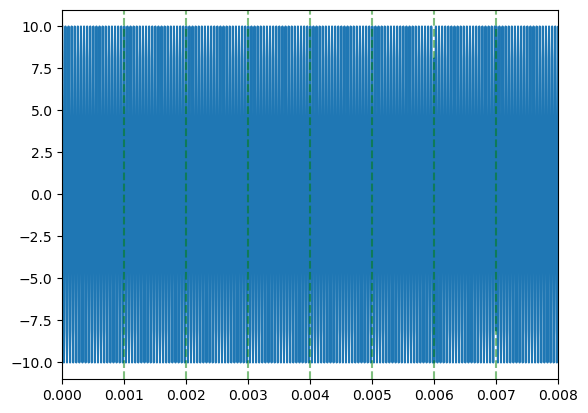

In [74]:
PREAMBLE_BITS = [0,0,0,0,0,0,1,0]*5
t, preamble_waveform, phase_shifts = bpsk_modulate(PREAMBLE_BITS,  bit_rate=bit_rate, carrier_freq=carrier_freq, sampling_rate=samplerate)
plt.plot(t, preamble_waveform)
for i in range(N_words_to_plot *N_bits_to_plot):
    plt.axvline(i/bit_rate, color='g', linestyle='--', alpha=0.5)



plt.xlim(0, N_words_to_plot*N_bits_to_plot/bit_rate)


done correlation
BIT START: 611766


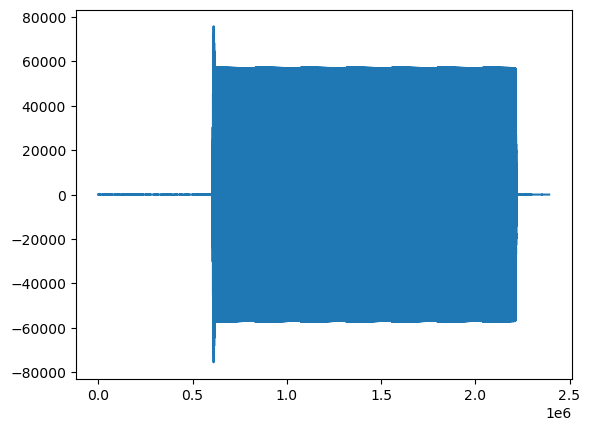

In [75]:
# Correlate with preamble to find start of message
received_signal = voltage_out
correlation = np.correlate(received_signal, preamble_waveform, mode='valid')
print("done correlation")
bit_start = np.argmax(correlation)
print("BIT START:", bit_start)

plt.plot(correlation)
plt.show()

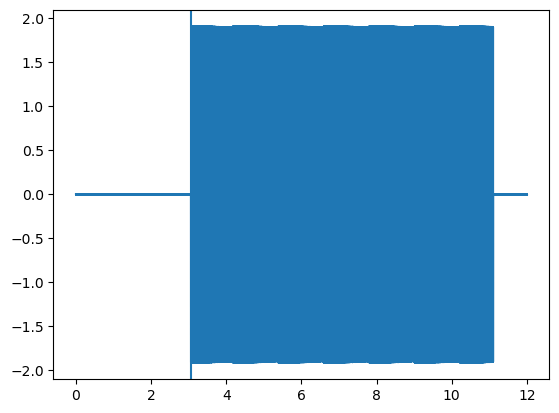

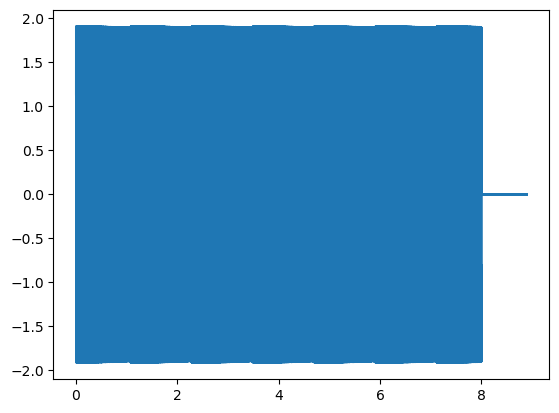

Decoded messageaaaaaaaaaaaaaaaaaa:
                                                                                                                                   ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿð                                                                              

(0.0, 0.008)

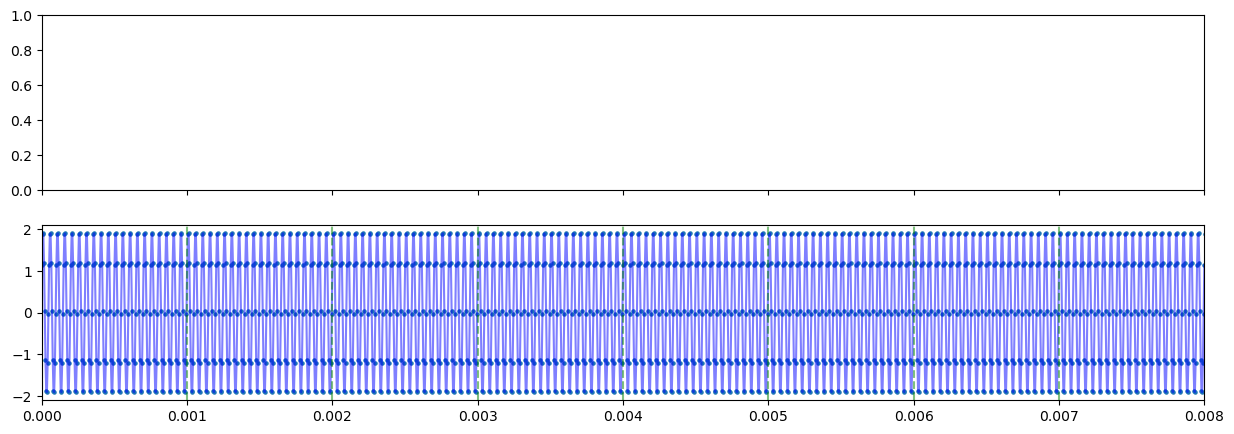

In [76]:
carrier_freq = 20e3
bit_rate = 1000




# Sending Signal -------------------------
# message = "The quick brown fox jumps over the lazy dog."
# bitstream = string_to_bitstream(message)
# # Add preamble to the bitstream
# bitstream = PREAMBLE_BITS + bitstream
# t, modulated, phase_shifts = bpsk_modulate(bitstream, bit_rate=bit_rate, carrier_freq=carrier_freq, sampling_rate=samplerate)

# # Receiving signal, add random noise -------------------------
# noise = np.random.normal(0, 5, size=modulated.shape)
# noise1 = np.sin(2 * np.pi * 50 * t) * 5
# received_signal =(modulated + noise + noise1) * 0.1

# # Add a delay to the received signal
# delay = 0.1
# delay_samples = int(delay * samplerate)
# received_signal = np.concatenate((np.zeros(delay_samples), received_signal))

#received_signal = daq.read(duration, readChannels)

received_signal = voltage_out
timee = daq.getTimeArray(duration, samplerate)
plt.plot(timee, received_signal)



plt.axvline(timee[bit_start])
plt.show()
idx = bit_start + len(preamble_waveform)
idx = idx - 2
received_signal = received_signal[idx:]
# Slice the received signal and begin coutning at 0 again
t1 = timee[idx:] - timee[idx]
plt.plot(t1,received_signal)
plt.show()
# Demodulate the received signal
bpsk_demodulated = bpsk_demodulate(received_signal, bit_rate=bit_rate, carrier_freq=carrier_freq, sampling_rate=samplerate)
T_bit = 1 / bit_rate

# t1 = np.arange(0, (len(bitstream)-80)* T_bit, 1 / samplerate)

#print("Bpsk demoulated:", bpsk_demodulated)
# # Example:
decoded = bitstream_to_string(bpsk_demodulated)

# print("Original Message: ", message)
print("Decoded messageaaaaaaaaaaaaaaaaaa:")  # Should print "hello_world"
print(decoded)
# print("number of samples per bit: ", int(samplerate/bit_rate))
# print("Numbw=er of periods in bit:", carrier_freq/(bit_rate))
# print("duration of one bit: ", 1/bit_rate)
# print("Number of bits: ", len(bitstream))
# print("Duration whole message: ", len(bitstream)/bit_rate)



# # Plot the original and demodulated signals
# print("Original Bitstream:    ", bitstream)
# print("Demodulated Bitstream: ", bpsk_demodulated)
# accuracy = 0 #= compare_bitstreams(bitstream, bpsk_demodulated)
# print(f"Accuracy: {accuracy:.2f}%")

# # Plot Original data
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(15,5))
# plt.suptitle(f"BPSK Signal Modulation carrierfreq: {carrier_freq}Hz, bitrate: {bit_rate}bps, duration: {len(bitstream)/bit_rate}s")
# ax1.plot(t, modulated, color='blue', alpha=0.5)
# ax1.scatter(t, modulated, s=5)
# ax1.set_title("Transmitted Modulated Signal")

#ax2.set_title(f"Received Modulated Signal.  Accuracy:{accuracy}%, N samps per bit: {int(samplerate/bit_rate)}, N periods in bit: {carrier_freq/(bit_rate)},N bits: {len(bitstream)} ")
ax2.plot(t1, received_signal, color='blue', alpha=0.5)
ax2.scatter(t1, received_signal, s=5)

# ax1.fill_between(t, np.min(modulated), np.max(modulated), where=phase_shifts>0, color='pink', alpha=0.4)
# ax1.fill_between(t, np.min(modulated), np.max(modulated), where=phase_shifts==0, color='orange', alpha=0.4)
#ax2.fill_between(t, np.min(received_signal), np.max(received_signal), where=phase_shifts>0, color='pink', alpha=0.4)
#ax2.fill_between(t, np.min(received_signal), np.max(received_signal), where=phase_shifts==0, color='orange', alpha=0.4)

N_bits_to_plot = 8
N_words_to_plot = 1
# for i in range(N_words_to_plot *N_bits_to_plot):
#     ax1.axvline(i/bit_rate, color='g', linestyle='--')
for i in range(N_words_to_plot *N_bits_to_plot):
    ax2.axvline(i/bit_rate, color='g', linestyle='--', alpha=0.5)



plt.xlim(0, N_words_to_plot*N_bits_to_plot/bit_rate)
# ax2.set_xlabel("Time [s]")
# fig.text(0.003,0.5, 'Amplitude [V]', va='center', rotation='vertical')









# plt.tight_layout()
# plt.show()



In [77]:
decoded = bitstream_to_string(bpsk_demodulated)

def flip_bits(bit_array):
    return 1 - bit_array

print("Decoded messageaaaaaaaaaaaaaaaaaa:")  # Should print "hello_world"
print(bpsk_demodulated)
print(flip_bits(np.asarray(bpsk_demodulated)))
print(bitstream_to_string(flip_bits(np.asarray(bpsk_demodulated))))


Decoded messageaaaaaaaaaaaaaaaaaa:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
from scipy.signal import butter, filtfilt

def lock_in_amplifier(voltages, samplerate, carrierFrequency):

        t = np.arange(len(voltages)) / samplerate

        time = len(voltages) / samplerate

        # Reference signals
        ref_cos = np.cos(2 * np.pi * carrierFrequency * t)
        ref_sin = np.sin(2 * np.pi * carrierFrequency * t)

        # Mix (multiply) input with references
        X = voltages * ref_cos
        Y = voltages * ref_sin

        X_amp = 1 / time * np.trapz(t, X)
        Y_amp = 1 / time * np.trapz(t, Y)

        print(X_amp, Y_amp)
        # Low-pass filter the mixed signals to extract DC component
        def lowpass(signal, cutoff=carrierFrequency / 5, order=3):
            nyquist = 0.5 * samplerate
            normal_cutoff = cutoff / nyquist
            b, a = butter(order, normal_cutoff, btype='low')
            return filtfilt(b, a, signal)

        X_filtered = lowpass(X)
        Y_filtered = lowpass(Y)



        # Compute amplitude and phase
        amplitude = 2 * np.sqrt(np.mean(X_filtered**2 + Y_filtered**2))
        phase = np.arctan2(np.mean(Y_filtered), np.mean(X_filtered))

        amplitude = 2 * np.sqrt(X_amp**2 + Y_amp**2)
        phase = np.arctan2(Y_amp, X_amp)

        return amplitude, phase

lock_in_amplifier(AI0_voltage, samplerate, 20e3)

KeyboardInterrupt: 

In [ ]:
daq = MyDAQ()
daq.name = 'MyDAQ1'

# Set some basic values
samplerate = 200000
daq.samplerate = samplerate
frequency = 70730
amplitude= 1
duration = 0.5
delta_f = 100

start_frequency = 1
end_frequency = 80000
frequencies = np.logspace(np.log10(start_frequency), np.log10(end_frequency), 50)
print(frequencies)
H_mags = []
H_phases = []
sigma_H_mags = []
SNRS = []
for frequency in frequencies:
    _, voltages = MyDAQ.generateWaveform('sine', samplerate=samplerate, frequency=frequency, amplitude=amplitude, duration=duration)


    # We define which channels to use 
    readChannels = ['AI0' , 'AI1']
    writeChannels = ['AO0']

    # Do the meaurement with MyDAQ
    AI0_voltage, AI1_voltage = daq.readwrite(voltages=voltages, readChannels=readChannels, writeChannels=writeChannels)

    voltage_in = AI0_voltage # Easier to define this way. THe first input channel is the voltage we put in the breadboard
    voltage_out = AI1_voltage # The second input channel is the voltage out over the breadboard component


    # we can now perform the FFT
    freqs_in, fft_in = daq.performRFFT(voltage_in, samplerate)
    freqs_out, fft_out = daq.performRFFT(voltage_out, samplerate)


    # First we calculate the mangitude transfer function
    power_in = daq.power(freqs_in, fft_in, frequency, delta_f)
    power_out = daq.power(freqs_out, fft_out, frequency, delta_f)

    H_mag = np.sqrt(power_out / power_in)

    
        
    #get the power by integrating over the interval
    interval1 = (freqs_out < (frequency - delta_f) ) & (freqs_out > 10)
    interval2 =  (freqs_out > (frequency + delta_f))
    SNR = power_out / (integrate.trapz(np.abs(fft_out[interval1])**2, freqs_out[interval1]) + integrate.trapz(np.abs(fft_out[interval2])**2, freqs_out[interval2]))	

    sigma_power = power_out / np.sqrt(SNR)
    sigma_H_mag =sigma_power / (2 * np.sqrt(power_out))
    # Now we calculate the phase transfer function
    
    index = np.abs(fft_in - frequency).argmin() # Index closest to the frequency of interest
    phase_in =  np.angle(fft_in[index])
    phase_out = np.angle(fft_out[index])

    H_phase = (np.rad2deg(phase_out - phase_in))
    if H_phase > 50:
        H_phase -= 360 

    H_mags.append(H_mag)
    H_phases.append(H_phase)
    sigma_H_mags.append(sigma_H_mag)
    SNRS.append(SNR)




sigma_H_mags = np.array(sigma_H_mags)
H_mags = np.array(H_mags)
H_phases = np.array(H_phases)
SNRS = np.array(SNRS)

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(8, 8))
# Now we plot the results
#plt.errorbar(frequencies, 20*np.log10(H_mags), yerr=20*sigma_H_mags/(np.log(10) * H_mags), fmt='o')
ax1.errorbar(frequencies, 20*np.log10(H_mags), fmt='o', label='data', markersize=3, yerr=20*sigma_H_mags/(np.log(10) * H_mags) / 10)
ax1.set_ylabel('Gain [dB]')
ax1.set_xscale('log')
ax2.errorbar(frequencies, H_phases,  fmt='o', markersize=3, yerr= np.abs(H_phases / np.sqrt(SNRS) / 10))
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Phase [Degrees]')
plt.suptitle('Bode plot of Blackbox 12')
plt.tight_layout()
plt.savefig('pdf/highpass.pdf')	
plt.show()





# We

# Debuq time!!!
print(f'{frequency}Hz, Power in: {power_in:.2f}, Power out: {power_out:.2f}')

print(f'H_mag: {H_mag:.2f}, Gain:{20*np.log10(H_mag):.2f}dB')
print(f'H_phase: {H_phase:.2f}')

